# Pedigree aproximation

The distribution of a quantitative trait within a popualtion can generally be aproximated with a normal distribution of constant variance. Even under strong seleciton the variance of this distribution is often only minimally effected. the one process that can cause significant departures from normality is gene flow. This is because gene flow can cause significant amounts of linkage disequilibrium creating correlations betwen combinations of allels that inflate the variance of the trait distribution and cause departures from normality. 

Models can account for linkage disequilibirum by explicitly tracking the full trait distirubtion with funtion aproximation techniques. However, this method is reletively computationally expensive and does not track the structure of the linkage disequilibirum. Here I develop a new method to track this distribution by tracking the linkage disequilbirium explicitly. Tracking the linkage state provides a computational advantage because the distribution of the trait conditional on linkage state is normal with a constant varaince.  

In [16]:
include("pedigreeAproximation.jl")
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
using Distributions
theme(:wong2)

In [17]:
# initialize demographic model - paramters loaded from DemographicParameters.jl 
mod1 = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod1)
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.05
min = -5
max = 10 
Δz = 0.05

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

# Test reproduction 

There are some small differences, but I don't think these are a problem at this point. I think it comes down to How I am aproximating the variance in this model  

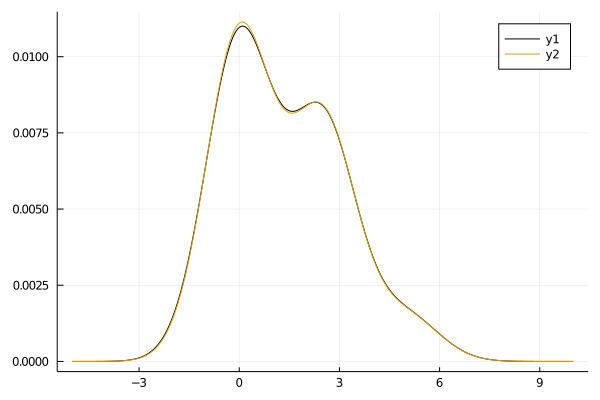

In [18]:
# initialize populations 
pop1 = pedigreeAproximation.init_population(mod1,  θ, s,5,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
im1 = pedigreeAproximation.init_immigrants(floor(Int, R_im),μ_im)

pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

amax = 50
# update pedigree aproximation population for test
pop1.zH .=  5.0
a = pop1.abundanceN[1:50]
pop1.abundanceN[1:50] = 0.5*a
pop1.abundanceH[1:50] = 0.5*a

function distribution(x,pi,z)
    return sum(broadcast(i -> pi[i]*pdf(Distributions.Normal(z[i],1.0),x), 1:length(pi)))
end 


# make plot 
grid = min:Δz:max
z,pi,N1 = pedigreeAproximation.reproduction(pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
    
    
# update trait distribution population for test
n = pop.abundanceN[1:amax]
pop.abundanceN[1:amax] .= 0.5*n
pop.abundanceH[1:amax] .= 0.5*n

dsn1 = pdf.(Distributions.Normal(0,1.0),pop.grid)
dsn2 = pdf.(Distributions.Normal(5.0,1.0),pop.grid)

pop.traitN[:,1:amax] .=  dsn1 ./ sum(dsn1)
pop.traitH[:,1:amax] .=  dsn2 ./ sum(dsn2)

dsn, N =  AgeTraitStructuredModels.reproduction(pop)

Plots.plot!(p1,pop.grid,dsn)

In [19]:
println(N1)
println(N)

2.884420264530703e13
2.884420264530703e13


# Test selection

again this seems pretty close, probabily not the cause of the large differnces seen in the simulations

30.877985005983156
30.877585935704012


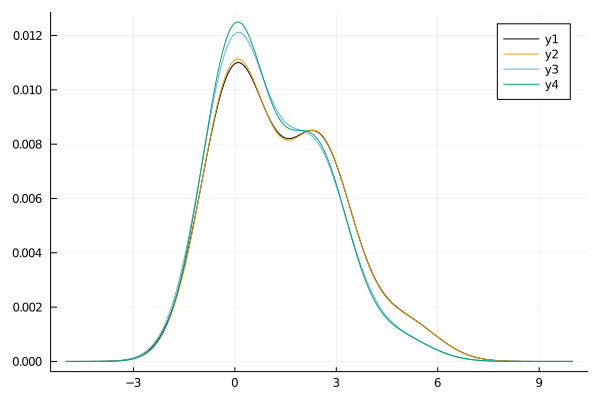

In [20]:
z,pi,N1=pedigreeAproximation.selection(z,pi,N1,pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
Plots.plot!(p1,grid, dsn1 ./ sum(dsn1))

println(log(N1))

dsn, N = AgeTraitStructuredModels.selection(dsn, N, pop)

println(log(N))
Plots.plot!(p1,grid, dsn ./ sum(dsn))

# Test Recruitment 

In [21]:
N1 = 5*10^13
N  = 5*10^13
z, pi, N1 = pedigreeAproximation.recruitment(z, pi, N1, pop1, true)

N = AgeTraitStructuredModels.recruitment(N, pop, true)

println(N1)
println(N)

77
73.30089061490956


# Test aging 

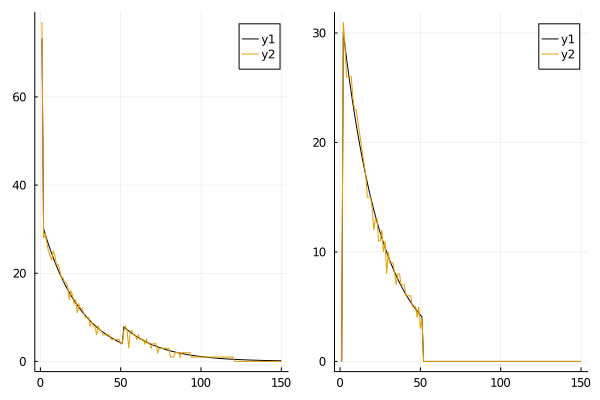

In [22]:


pedigreeAproximation.ageing!(pop1, z, pi, N1, 0, 5.0)
AgeTraitStructuredModels.ageing!(pop, N, dsn)
p1 = Plots.plot(pop.abundanceN )
Plots.plot!(p1, pop1.abundanceN )

p2 = Plots.plot(pop.abundanceH )
Plots.plot!(p2, pop1.abundanceH )
plot(p1,p2)

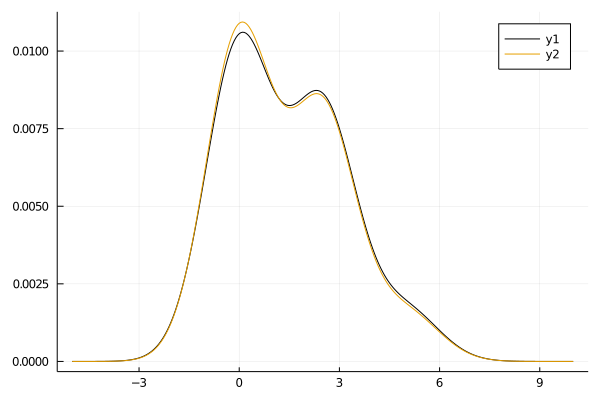

In [23]:
grid = min:Δz:max
z,pi,N1 = pedigreeAproximation.reproduction(pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
    

dsn, N =  AgeTraitStructuredModels.reproduction(pop)
Plots.plot!(p1,pop.grid,dsn)
p1

# Test fitness

In [24]:
theta = pop1.theta
s = pop1.s
V = pop1.V
V_prime = (s+1/V)^(-1)
z_prime = V_prime.*(s*theta .+ z./V)
p_survival = broadcast(i -> pedigreeAproximation.prop_survival(z[i],z_prime[i],s,theta,V, V_prime),1:length(z))
println(sum(p_survival .* pi))


x, N2 = AgeTraitStructuredModels.selection(dsn, 1.0, pop)
println(N2)

0.8861699834969017
0.8884838220896871


# Test recruitment

Again clearly not the issue

In [25]:
z1, pi1, N1 = pedigreeAproximation.recruitment(z, pi, 1.0*10^13, pop1, true)

N =AgeTraitStructuredModels.recruitment(1.0*10^13, pop )
println(N1)
println(N)

35
39.380732502853085


# Test update function 

In [26]:
include("pedigreeAproximation.jl")
# initialize populations 
pop1 = pedigreeAproximation.init_population(mod1,  θ, s,5,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
im1 = pedigreeAproximation.init_immigrants(floor(Int, R_im),μ_im)

pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

amax = 50
# update pedigree aproximation population for test
pop1.zH .=  5.0
a = pop1.abundanceN[1:amax]
pop1.abundanceN[1:amax] = 0.5*a
pop1.abundanceH[1:amax] = 0.5*a


function distribution(x,pi,z)
    return sum(broadcast(i -> pi[i]*pdf(Distributions.Normal(z[i],1.0),x), 1:length(pi)))
end 



# make plot 
grid = min:Δz:max
z1,pi1=pedigreeAproximation.time_step_DSI!(pop1, 20, 5.0)
pi = pop1.pi[:,1] 
z = pop1.z[:,1] 


dsn1 = broadcast(x -> distribution(x,pi1,z1), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
Plots.plot!(p1,grid, dsn1 ./ sum(dsn1))

    
# update trait distribution population for test
n = pop.abundanceN[1:amax]
pop.abundanceN[1:amax] .= 0.5*n
pop.abundanceH[1:amax] .= 0.5*n

dsn1 = pdf.(Distributions.Normal(0,1.0),pop.grid)
dsn2 = pdf.(Distributions.Normal(5.0,1.0),pop.grid)

pop.traitN[:,1:amax] .=  dsn1 ./ sum(dsn1)
pop.traitH[:,1:amax] .=  dsn2 ./ sum(dsn2)

AgeTraitStructuredModels.time_step_DSI!(pop,im)
Plots.plot!(p1,pop.grid,pop.traitN[:,1])

LoadError: [91mBoundsError: attempt to access Float64[39m
[91m  at index [2][39m

# Test with simulations 

Despite the small differnces between the results in the previous sections it seems like the produce similar results in simulations. 

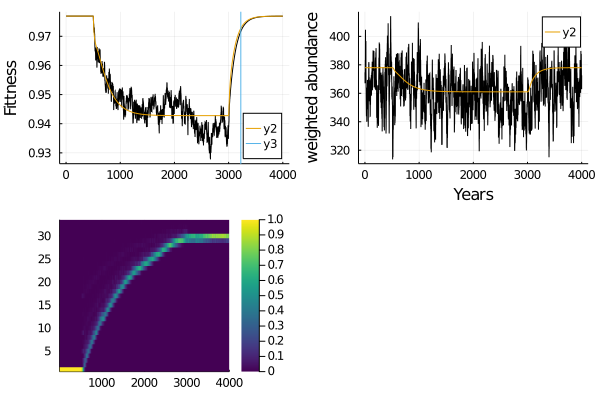

In [116]:
include("pedigreeAproximation.jl")
# initialize populations 
μ_im = 6.0
R_im = 5.0
mod1 = DemographicParameters.mod_Smyth_2016_5year
pop1 = pedigreeAproximation.init_population(mod1,  θ, s,5,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
im1 = pedigreeAproximation.init_immigrants(floor(Int, R_im),μ_im)

pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)



T = 4000
t_stock = 500
T_stock = 3000

fitness = zeros(T)
SSB = zeros(T)

fitness1 = zeros(T)
SSB1 = zeros(T)

pisum = zeros(pop1.m,T)
for t in 1:T
    if t < t_stock
 
        piN = pedigreeAproximation.time_step_DSI!(pop1,0, μ_im)
        AgeTraitStructuredModels.time_step_DSI!(pop)
    elseif t < T_stock

        piN =pedigreeAproximation.time_step_DSI!(pop1,rand(Distributions.Poisson(R_im)),μ_im)
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
    else

    piN =pedigreeAproximation.time_step_DSI!(pop1,0.0,μ_im)
        AgeTraitStructuredModels.time_step_DSI!(pop)
    end 

    fitness[t] = pedigreeAproximation.fitness(pop1)
    SSB[t] = pedigreeAproximation.SSB(pop1)
    pisum[:,t] = pop1.pi[:,1]
    fitness1[t] = AgeTraitStructuredModels.fittness(pop)
    SSB1[t] = AgeTraitStructuredModels.spawning_stock(pop) #+AgeTraitStructuredModels.spawning_stockH(pop)

end 
p1 = Plots.plot(fitness, ylab = "Fittness", label = "", legend =:bottomright)
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p1, fitness1)
Plots.vline!(p1,[T_stock + 1.5*150])
Plots.plot!(p2, SSB1)
p3 = Plots.heatmap(pisum, label = "")
plot(p1,p2,p3)

# test reletive performance
One goal of the pedigre aproximation is to be more computationally efficent. This is true for n < 7, despite minimal optimization of the code. 

In [117]:
@time pedigreeAproximation.time_step_DSI!(pop1,0, 5.0)
@time AgeTraitStructuredModels.time_step_DSI!(pop,im)
print(" ")

  0.000264 seconds (725 allocations: 120.328 KiB)
  0.000575 seconds (260 allocations: 362.469 KiB)
 

# Test aproximation with fixed trait distribution conditional on the pedigree
This aproximation does a pretty good job initially, but does nto solve any computational bottelnecks

In [114]:
include("pedigreeAproximation.jl")
pop1 = pedigreeAproximation.init_population(mod1,θ,s,4,1.0)
#im1 = pedigreeAproximation.init_immigrants(pop1,floor(Int, R_im),μ_im)

pop2 = pedigreeAproximation.init_population_fixed(mod1,θ,s,4,μ_im)

T = 1500
t_stock = 500
T_stock = 700

fitness = zeros(T)
SSB = zeros(T)

fitness1 = zeros(T)
SSB1 = zeros(T)

for t in 1:T
    if t < t_stock
        pedigreeAproximation.time_step_DSI!(pop1,0, μ_im)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,0)
    elseif t < T_stock
        pedigreeAproximation.time_step_DSI!(pop1,floor(Int, R_im),μ_im)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,floor(Int, R_im))
    else
        pedigreeAproximation.time_step_DSI!(pop1,0, μ_im)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,0)
    end 

    fitness[t] = pedigreeAproximation.fitness(pop1)
    SSB[t] = pedigreeAproximation.SSB(pop1)
    
    fitness1[t] = pedigreeAproximation.fitness_fixed(pop2)
    SSB1[t] = pedigreeAproximation.SSB(pop2) 

end 
p1 = Plots.plot(fitness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p1, fitness1)
Plots.plot!(p2, SSB1)
plot(p1,p2)

LoadError: [91mtype population_fixed has no field abundanceN[39m

# Reletive performance


In [115]:
@time pedigreeAproximation.time_step_DSI!(pop1)
@time pedigreeAproximation.time_step_fixed_DSI!(pop2,0)

LoadError: [91mMethodError: no method matching time_step_DSI!(::Main.pedigreeAproximation.population)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  time_step_DSI!(::Any, [91m::Any[39m, [91m::Any[39m) at /Users/johnbuckner/github/domestication_selection_model/New/pedigreeAproximation.jl:390[39m

# Find computational bottlenecks

In [ ]:
z,pi,n = pedigreeAproximation.reproduction(pop1)
z,pi,n =  pedigreeAproximation.recruitment(z, pi, n, pop1, true)

pedigreeAproximation.selection(z,pi,n,pop1)
pedigreeAproximation.immigration(z,pi,n,im1)
pedigreeAproximation.ageing_ip!(pop1,z,pi,n)

z,pi,n = pedigreeAproximation.reproduction(pop1)
z,pi,n =  pedigreeAproximation.recruitment(z, pi, n, pop1, true)

@time pedigreeAproximation.reproduction(pop1)
@time pedigreeAproximation.selection(z,pi,n,pop1)
@time pedigreeAproximation.immigration(z,pi,n,im1)
@time pedigreeAproximation.ageing_ip!(pop1,z,pi,n)

# Test semelparous populations

In [268]:
include("pedigreeAproximation.jl")
using Distributions
# dempgraphic
r = 3
K = 5000
p_im = 0.1
Nt = vcat(zeros(0), repeat([K], 10))

# selection
theta = 0 
s = 0.05

# aprox
n = 5

# population 
pop = pedigreeAproximation.init_simplePopulation(r,K,  theta, s,n)


Main.pedigreeAproximation.simplePopulation(5, 33, [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.9563568227936243, 5000.0, 0.0, 1.0236297383036903, 3.0, 5000.0, 0.05, 0.0)

In [269]:
zH = 5.0
pedigreeAproximation.time_step_simple!(pop,zH,rand(Distributions.Binomial(Nt[1],p_im)))

5.0

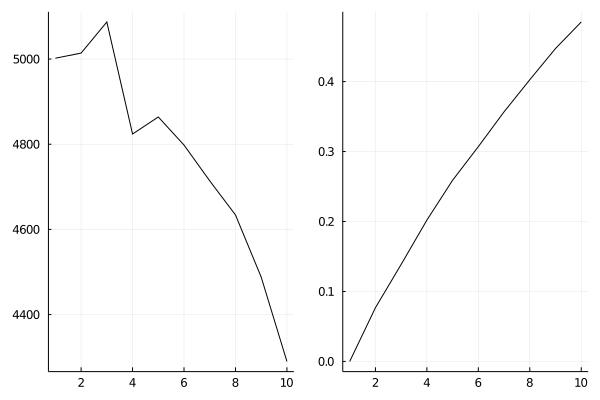

In [270]:
pop = pedigreeAproximation.init_simplePopulation(r,K,  theta, s,n)
using StatsBase
T = length(Nt)
Nls = zeros(T)
pedigree = zeros(T)
pedigree_sample = []
nSample = zeros(T)
nH = zeros(T)
n_sample = 20

for i in 1:T
    pedigreeAproximation.time_step_simple!(pop,zH,rand(Distributions.Binomial(Nt[i],p_im)))
    Nls[i] = pop.N
    pedigree[i] = sum(pop.pi .* (0:pop.m.-1) ./(pop.m-1) )
    push!(pedigree_sample, StatsBase.sample(collect((0:pop.m.-1) ./(pop.m-1)), StatsBase.weights(pop.pi), n_sample;replace = true))
    nH[i] = rand(Distributions.Binomial(n_sample,pop.H/(pop.N+pop.H)))
    nSample[i] = n_sample
end 

p1 = Plots.plot(Nls, label = "")
p2 = Plots.plot(pedigree, label = "")

plot(p1,p2)

In [272]:
simpleParticleFilters.recruits_pedigree(pedigree_sample[10],pop)
simpleParticleFilters.estiamteH(nSample[10],nH[10],pop)

-67.14650987573896

In [283]:
include("simpleParticleFilter.jl")

T_end = 10
#Nt =  Nt
time_step! = pedigreeAproximation.time_step_simple!
t_pedigree = collect(1:10)
t_recruitsN = []
t_sampleH = collect(1:10)
#nSample = nSample
#nH = nH
pedigrees = pedigree_sample
recruitsN = []
precision = 1.0

data = simpleParticleFilters.data(T_end,Nt,time_step!,t_pedigree,t_recruitsN,t_sampleH,nSample,nH,pedigrees,recruitsN,precision)

r = 3.0
K = 5000
p_im = 0.1
s = 0.05
RRS = 0.3

params = simpleParticleFilters.params(r,K,p_im,s,RRS)

Main.simpleParticleFilters.params(3.0, 5000.0, 0.1, 0.05, 0.3)

In [284]:
simpleParticleFilters.likelihood(params, data; N_particles = 100, n = 4)

LoadError: [91mMethodError: no method matching log(::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  log([91m::Irrational{:ℯ}[39m) at mathconstants.jl:95[39m
[91m[0m  log([91m::Irrational{:ℯ}[39m, [91m::Number[39m) at mathconstants.jl:96[39m
[91m[0m  log([91m::Float32[39m) at special/log.jl:289[39m
[91m[0m  ...[39m